Boilerplate

In [115]:
import gc
import math
from typing import List

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_dct as dct
from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
torch._dynamo.config.cache_size_limit = 16 # type: ignore
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


In [117]:
df = sns.load_dataset('diamonds')
df = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut']]

df['cut'] = (df['cut'] == 'Ideal').astype(int)

X = df.drop('cut', axis=1)
y = df['cut']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(X.shape, y.shape)

(53940, 7) (53940,)


In [ ]:
def gaussian_dct_smooth(
    signal: torch.Tensor,
    smoothness_weight: float,
    dim: int = -1
) -> torch.Tensor:
    if not signal.is_floating_point():
        raise TypeError("Input must be a floating point tensor.")

    original_dtype = signal.dtype
    working_signal = signal

    if original_dtype in (torch.float16, torch.bfloat16):
        working_signal = working_signal.to(torch.float32)

    working_signal = working_signal.movedim(dim, -1)
    axis_length = working_signal.size(-1)

    freq_idx = torch.arange(axis_length, device=working_signal.device, dtype=working_signal.dtype)
    omega = 2 * torch.sin(math.pi * freq_idx / (2 * axis_length))
    gaussian_filter = torch.exp(-smoothness_weight * omega**2)

    dct_coeffs = dct.dct(working_signal, norm="ortho") * gaussian_filter
    smoothed_signal = dct.idct(dct_coeffs, norm="ortho")

    return smoothed_signal.movedim(-1, dim).to(original_dtype)

In [118]:
def train(
    model,
    criterion,
    optimizers: List[torch.optim.Optimizer],
    epochs: int,
    *,
    warmup_epochs = 100
):
    plt.rcParams['animation.embed_limit'] = 50

    torch.set_printoptions(threshold=float("inf"))

    best_test_loss = float("inf")
    train_losses: list[float] = []
    test_losses: list[float] = []
    learning_rates: list[float] = []

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    schedulers = [
        torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, factor=0.99999, patience=0, threshold=0, eps=0
        )
        for opt in optimizers
    ]

    for epoch in range(1, epochs + 1):
        if epoch <= warmup_epochs:
            warmup_scale = epoch / warmup_epochs
            for opt in optimizers:
                for group in opt.param_groups:
                    group["lr"] = group.get("base_lr", group["lr"]) * warmup_scale

        model.train()
        for opt in optimizers:
            opt.zero_grad()

        train_outputs = model(X_train_tensor)

        train_loss = criterion(train_outputs, y_train_tensor)
        train_loss.backward()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = (
                (test_predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
            )

        for opt in optimizers:
            opt.step()

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        learning_rates.append(schedulers[0].optimizer.param_groups[0]["lr"])

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()

        if epoch > warmup_epochs:
            for sched in schedulers:
                sched.step(train_loss.item())

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch}/{epochs}, "
                f"Train Loss: {train_loss.item():.6f}, "
                f"Test Loss: {test_loss.item():.6f}, "
                f"Test Acc: {test_accuracy:.4f}, "
                f"LR: {schedulers[0].optimizer.param_groups[0]['lr']:.4e}"
            )
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(
            f"[GPU] Peak memory allocated: "
            f"{torch.cuda.max_memory_allocated() / 1024 ** 2:.2f} MB"
        )
        print(
            f"[GPU] Peak memory reserved: "
            f"{torch.cuda.max_memory_reserved() / 1024 ** 2:.2f} MB"
        )

    print()
    print(f"Lowest Test Loss: {best_test_loss:.8f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(summary(model, input_data=X_train_tensor))

In [124]:
class KANLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, init: str, num_control_points: int):
        super().__init__()
        self.in_features, self.out_features, self.num_control_points = in_features, out_features, num_control_points
        self.kan_weight = nn.Parameter(torch.zeros(in_features, num_control_points, out_features))
        self.register_buffer("local_bias", torch.arange(num_control_points).view(1, -1, 1))
        self.register_buffer("feature_offset", torch.arange(in_features).view(1, -1) * num_control_points)

        centered_bias = self.local_bias.float() - (num_control_points - 1) / 2.0 # type: ignore

        if init == 'random_normal':
            slopes = torch.randn(in_features, out_features, device=self.kan_weight.device)
            slopes /= slopes.norm(dim=0, keepdim=True).clamp_min(1e-12)
        elif init == 'identity':
            if in_features != out_features:
                raise ValueError("'identity' init requires in_features == out_features.")
            slopes = torch.eye(in_features, device=self.kan_weight.device)
        elif init != 'none':
            raise ValueError("init must be 'random_normal', 'identity', or 'none'.")
        else:
            return  # leave weights as zeros

        with torch.no_grad():
            self.kan_weight.copy_(centered_bias * slopes.unsqueeze(1))

    def forward(self, x):
        # x: (batch_size, in_features)
        
        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2) # (batch_size, in_features)
        lower_indices = lower_indices_float.long() + self.feature_offset # (batch_size, in_features)

        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1) # (batch_size, in_features, 2)
        vals = F.embedding(indices, self.kan_weight.view(-1, self.out_features)) # (batch_size, in_features, 2, out_features)

        lower_val, upper_val = vals.unbind(dim=2) # each: (batch_size, in_features, out_features)
        return torch.lerp(lower_val, upper_val, (x - lower_indices_float).unsqueeze(-1)).sum(dim=1) # (batch_size, out_features)

    def visualize_all_mappings(self, save_path=None):
        interp_tensor = self.kan_weight.detach().cpu().view(self.in_features, self.num_control_points, self.out_features)

        fig, axes = plt.subplots(
            self.in_features,
            self.out_features,
            figsize=(4 * self.out_features, 3 * self.in_features)
        )

        # Always get a 2D array of shape (in_features, out_features)
        axes = np.array(axes, dtype=object).reshape(self.in_features, self.out_features)

        for i in range(self.in_features):
            for j in range(self.out_features):
                ax = axes[i, j]
                ax.plot(interp_tensor[i, :, j])
                ax.set_title(f'In {i} → Out {j}')
                ax.set_xlabel('Control Points')
                ax.set_ylabel('Value')
                ax.grid(True)

        fig.suptitle("KAN Layer Mappings", fontsize=16, y=1.02)
        fig.tight_layout()

        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {save_path}")

        plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KANLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, init: str, num_control_points: int):
        super().__init__()
        self.in_features  = in_features
        self.out_features = out_features
        self.num_control_points = num_control_points

        # Store as a flat embedding table: (in_features * num_control_points, out_features)
        self.kan_weight = nn.Parameter(
            torch.zeros(in_features * num_control_points, out_features)
        )

        # Offsets to map (feature, control_point) -> flat index
        # Shape: (in_features,), used as base for every batch element
        self.register_buffer(
            "feature_offset",
            torch.arange(in_features) * num_control_points
        )

        # ----- Initialization (same behavior as before) -----
        if init == 'random_normal':
            slopes = torch.randn(in_features, out_features, device=self.kan_weight.device)
            slopes /= slopes.norm(dim=0, keepdim=True).clamp_min(1e-12)
        elif init == 'identity':
            if in_features != out_features:
                raise ValueError("'identity' init requires in_features == out_features.")
            slopes = torch.eye(in_features, device=self.kan_weight.device)
        elif init == 'none':
            return  # leave zeros
        else:
            raise ValueError("init must be 'random_normal', 'identity', or 'none'.")

        centered = torch.arange(num_control_points, device=self.kan_weight.device, dtype=torch.float32)
        centered = centered - (num_control_points - 1) / 2.0  # (K,)

        # Build (F, K, O) then flatten to (F*K, O) once, here in __init__
        with torch.no_grad():
            w_fko = slopes[:, None, :] * centered[None, :, None]   # (F, K, O)
            self.kan_weight.copy_(w_fko.reshape(-1, out_features))  # (F*K, O)

    def forward(self, x):
        # x: (batch_size, in_features)  # feature-major
        x = x.transpose(0, 1)  # (in_features, batch_size)

        # Compute lower control-point per (feature, batch)
        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2)  # (F, B)
        lower_indices = lower_indices_float.long() + self.feature_offset[:, None]  # (F, B)

        # Gather two neighbors directly from the flat embedding table
        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1)  # (F, B, 2)
        vals = F.embedding(indices, self.kan_weight)  # (F, B, 2, O)

        # Linear interpolation and sum over features
        lower_val, upper_val = vals.unbind(dim=2)  # each (F, B, O)
        out = torch.lerp(lower_val, upper_val, (x - lower_indices_float).unsqueeze(-1))  # (F, B, O)
        return out.sum(dim=0)  # (B, O)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KANLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, init: str, num_control_points: int):
        super().__init__()
        self.in_features  = in_features
        self.out_features = out_features
        self.num_control_points = num_control_points

        self.embedding = nn.Embedding(in_features * num_control_points, out_features)

        self.register_buffer("feature_offset", (torch.arange(in_features) * num_control_points).view(in_features, 1))  # (F, 1)

        if init == 'random_normal':
            slopes = torch.randn(in_features, out_features)
            slopes /= slopes.norm(dim=0, keepdim=True).clamp_min(1e-12)
        elif init == 'identity':
            if in_features != out_features:
                raise ValueError("'identity' init requires in_features == out_features.")
            slopes = torch.eye(in_features)
        elif init == 'none':
            return
        else:
            raise ValueError("init must be 'random_normal', 'identity', or 'none'.")

        centered = torch.arange(num_control_points, dtype=torch.float32)
        centered -= (num_control_points - 1) / 2.0  # (K,)

        with torch.no_grad():
            w_fko = slopes[:, None, :] * centered[None, :, None]  # (F, K, O)
            self.embedding.weight.copy_(w_fko.reshape(-1, out_features))  # flatten (F*K, O)

    def forward(self, x):
        # x: (batch_size, in_features)  # feature-major
        x = x.transpose(0, 1)  # (in_features, batch_size)

        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2)  # (F, B)
        lower_indices = lower_indices_float.long() + self.feature_offset  # (F, B)

        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1)  # (F, B, 2)

        # nn.Embedding lookup
        vals = self.embedding(indices)  # (F, B, 2, O)

        lower_val, upper_val = vals.unbind(dim=2)  # each (F, B, O)
        out = torch.lerp(lower_val, upper_val, (x - lower_indices_float).unsqueeze(-1))  # (F, B, O)
        return out.sum(dim=0)  # (B, O)


In [168]:
class StableNN(nn.Module):
    def __init__(self, in_features: int, mid_features: int, out_features: int, num_control_points: int, spline_range: int):
        super().__init__()
        self.num_control_points = num_control_points
        self.spline_range = spline_range

        self.mad_bn1 = nn.BatchNorm1d(in_features, affine=False)
        self.kan_layer1 = KANLayer(in_features=in_features, out_features=mid_features, num_control_points=num_control_points, init='random_normal')

        self.mad_bn2 = nn.BatchNorm1d(mid_features, affine=False)
        self.kan_layer2 = KANLayer(in_features=mid_features, out_features=mid_features, num_control_points=num_control_points, init='identity')

        self.mad_bn3 = nn.BatchNorm1d(mid_features, affine=False)
        self.kan_layer3 = KANLayer(in_features=mid_features, out_features=out_features, num_control_points=num_control_points, init='none')

    def forward(self, x):
        x = self.mad_bn1(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer1(x)

        x = self.mad_bn2(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer2(x)

        x = self.mad_bn3(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer3(x)
        return torch.cat([x, -x], dim=-1)

In [159]:
model = torch.compile(StableNN(in_features=X.shape[1], mid_features=7, out_features=1, num_control_points=32, spline_range=4), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * 100)]

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

Epoch 50/1000, Train Loss: 0.320534, Test Loss: 0.355849, Test Acc: 0.8665, LR: 5.0000e-02
Epoch 100/1000, Train Loss: 0.271899, Test Loss: 0.331208, Test Acc: 0.8742, LR: 1.0000e-01
Epoch 150/1000, Train Loss: 0.258301, Test Loss: 0.344553, Test Acc: 0.8717, LR: 9.9983e-02
Epoch 200/1000, Train Loss: 0.253942, Test Loss: 0.349854, Test Acc: 0.8687, LR: 9.9952e-02
Epoch 250/1000, Train Loss: 0.254095, Test Loss: 0.350733, Test Acc: 0.8747, LR: 9.9905e-02
Epoch 300/1000, Train Loss: 0.246998, Test Loss: 0.353438, Test Acc: 0.8724, LR: 9.9862e-02
Epoch 350/1000, Train Loss: 0.256828, Test Loss: 0.344675, Test Acc: 0.8746, LR: 9.9817e-02
Epoch 400/1000, Train Loss: 0.248168, Test Loss: 0.353964, Test Acc: 0.8690, LR: 9.9767e-02
Epoch 450/1000, Train Loss: 0.247028, Test Loss: 0.371492, Test Acc: 0.8693, LR: 9.9722e-02
Epoch 500/1000, Train Loss: 0.248737, Test Loss: 0.351048, Test Acc: 0.8743, LR: 9.9673e-02
Epoch 550/1000, Train Loss: 0.239451, Test Loss: 0.370659, Test Acc: 0.8688, LR: 

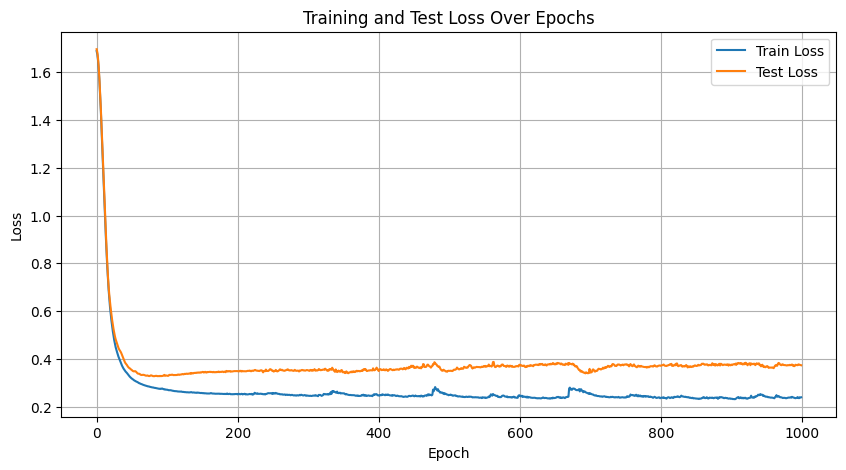

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─StableNN: 1-1                          [43152, 2]                3,360
Total params: 3,360
Trainable params: 3,360
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21


In [160]:
train(model, criterion, optimizers, epochs=1000, warmup_epochs=100) # type: ignore

Epoch 50/1000, Train Loss: 0.290519, Test Loss: 0.307602, Test Acc: 0.8795, LR: 5.0000e-02
Epoch 100/1000, Train Loss: 0.260171, Test Loss: 0.328193, Test Acc: 0.8752, LR: 1.0000e-01
Epoch 150/1000, Train Loss: 0.249044, Test Loss: 0.344827, Test Acc: 0.8718, LR: 9.9966e-02
Epoch 200/1000, Train Loss: 0.239548, Test Loss: 0.357824, Test Acc: 0.8696, LR: 9.9934e-02
Epoch 250/1000, Train Loss: 0.237659, Test Loss: 0.367565, Test Acc: 0.8681, LR: 9.9893e-02
Epoch 300/1000, Train Loss: 0.235514, Test Loss: 0.372394, Test Acc: 0.8664, LR: 9.9849e-02
Epoch 350/1000, Train Loss: 0.232383, Test Loss: 0.375032, Test Acc: 0.8656, LR: 9.9804e-02
Epoch 400/1000, Train Loss: 0.232399, Test Loss: 0.380200, Test Acc: 0.8650, LR: 9.9756e-02
Epoch 450/1000, Train Loss: 0.242945, Test Loss: 0.363143, Test Acc: 0.8691, LR: 9.9706e-02
Epoch 500/1000, Train Loss: 0.238276, Test Loss: 0.371860, Test Acc: 0.8692, LR: 9.9657e-02
Epoch 550/1000, Train Loss: 0.230277, Test Loss: 0.378781, Test Acc: 0.8657, LR: 

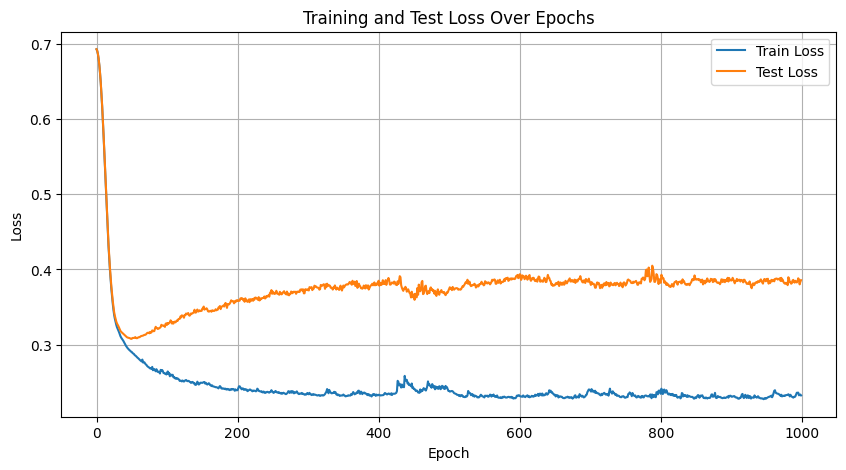

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─StableNN: 1-1                          [43152, 2]                3,360
Total params: 3,360
Trainable params: 3,360
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21


In [139]:
train(model, criterion, optimizers, epochs=1000, warmup_epochs=100) # type: ignore

Epoch 50/1000, Train Loss: 0.291656, Test Loss: 0.305581, Test Acc: 0.8836, LR: 5.0000e-02
Epoch 100/1000, Train Loss: 0.260650, Test Loss: 0.320937, Test Acc: 0.8778, LR: 1.0000e-01
Epoch 150/1000, Train Loss: 0.243744, Test Loss: 0.340635, Test Acc: 0.8718, LR: 9.9975e-02
Epoch 200/1000, Train Loss: 0.238163, Test Loss: 0.357244, Test Acc: 0.8699, LR: 9.9941e-02
Epoch 250/1000, Train Loss: 0.235812, Test Loss: 0.366540, Test Acc: 0.8689, LR: 9.9897e-02
Epoch 300/1000, Train Loss: 0.233625, Test Loss: 0.365985, Test Acc: 0.8691, LR: 9.9848e-02
Epoch 350/1000, Train Loss: 0.234891, Test Loss: 0.371218, Test Acc: 0.8672, LR: 9.9802e-02
Epoch 400/1000, Train Loss: 0.230842, Test Loss: 0.368615, Test Acc: 0.8687, LR: 9.9756e-02
Epoch 450/1000, Train Loss: 0.228486, Test Loss: 0.376998, Test Acc: 0.8696, LR: 9.9711e-02
Epoch 500/1000, Train Loss: 0.230615, Test Loss: 0.383644, Test Acc: 0.8670, LR: 9.9664e-02
Epoch 550/1000, Train Loss: 0.235670, Test Loss: 0.379634, Test Acc: 0.8687, LR: 

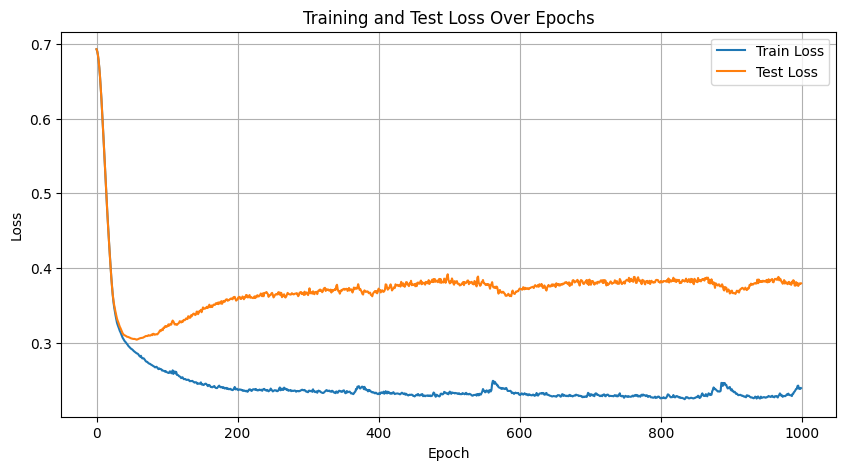

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─StableNN: 1-1                          [43152, 2]                3,360
Total params: 3,360
Trainable params: 3,360
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21


In [127]:
train(model, criterion, optimizers, epochs=1000, warmup_epochs=100) # type: ignore

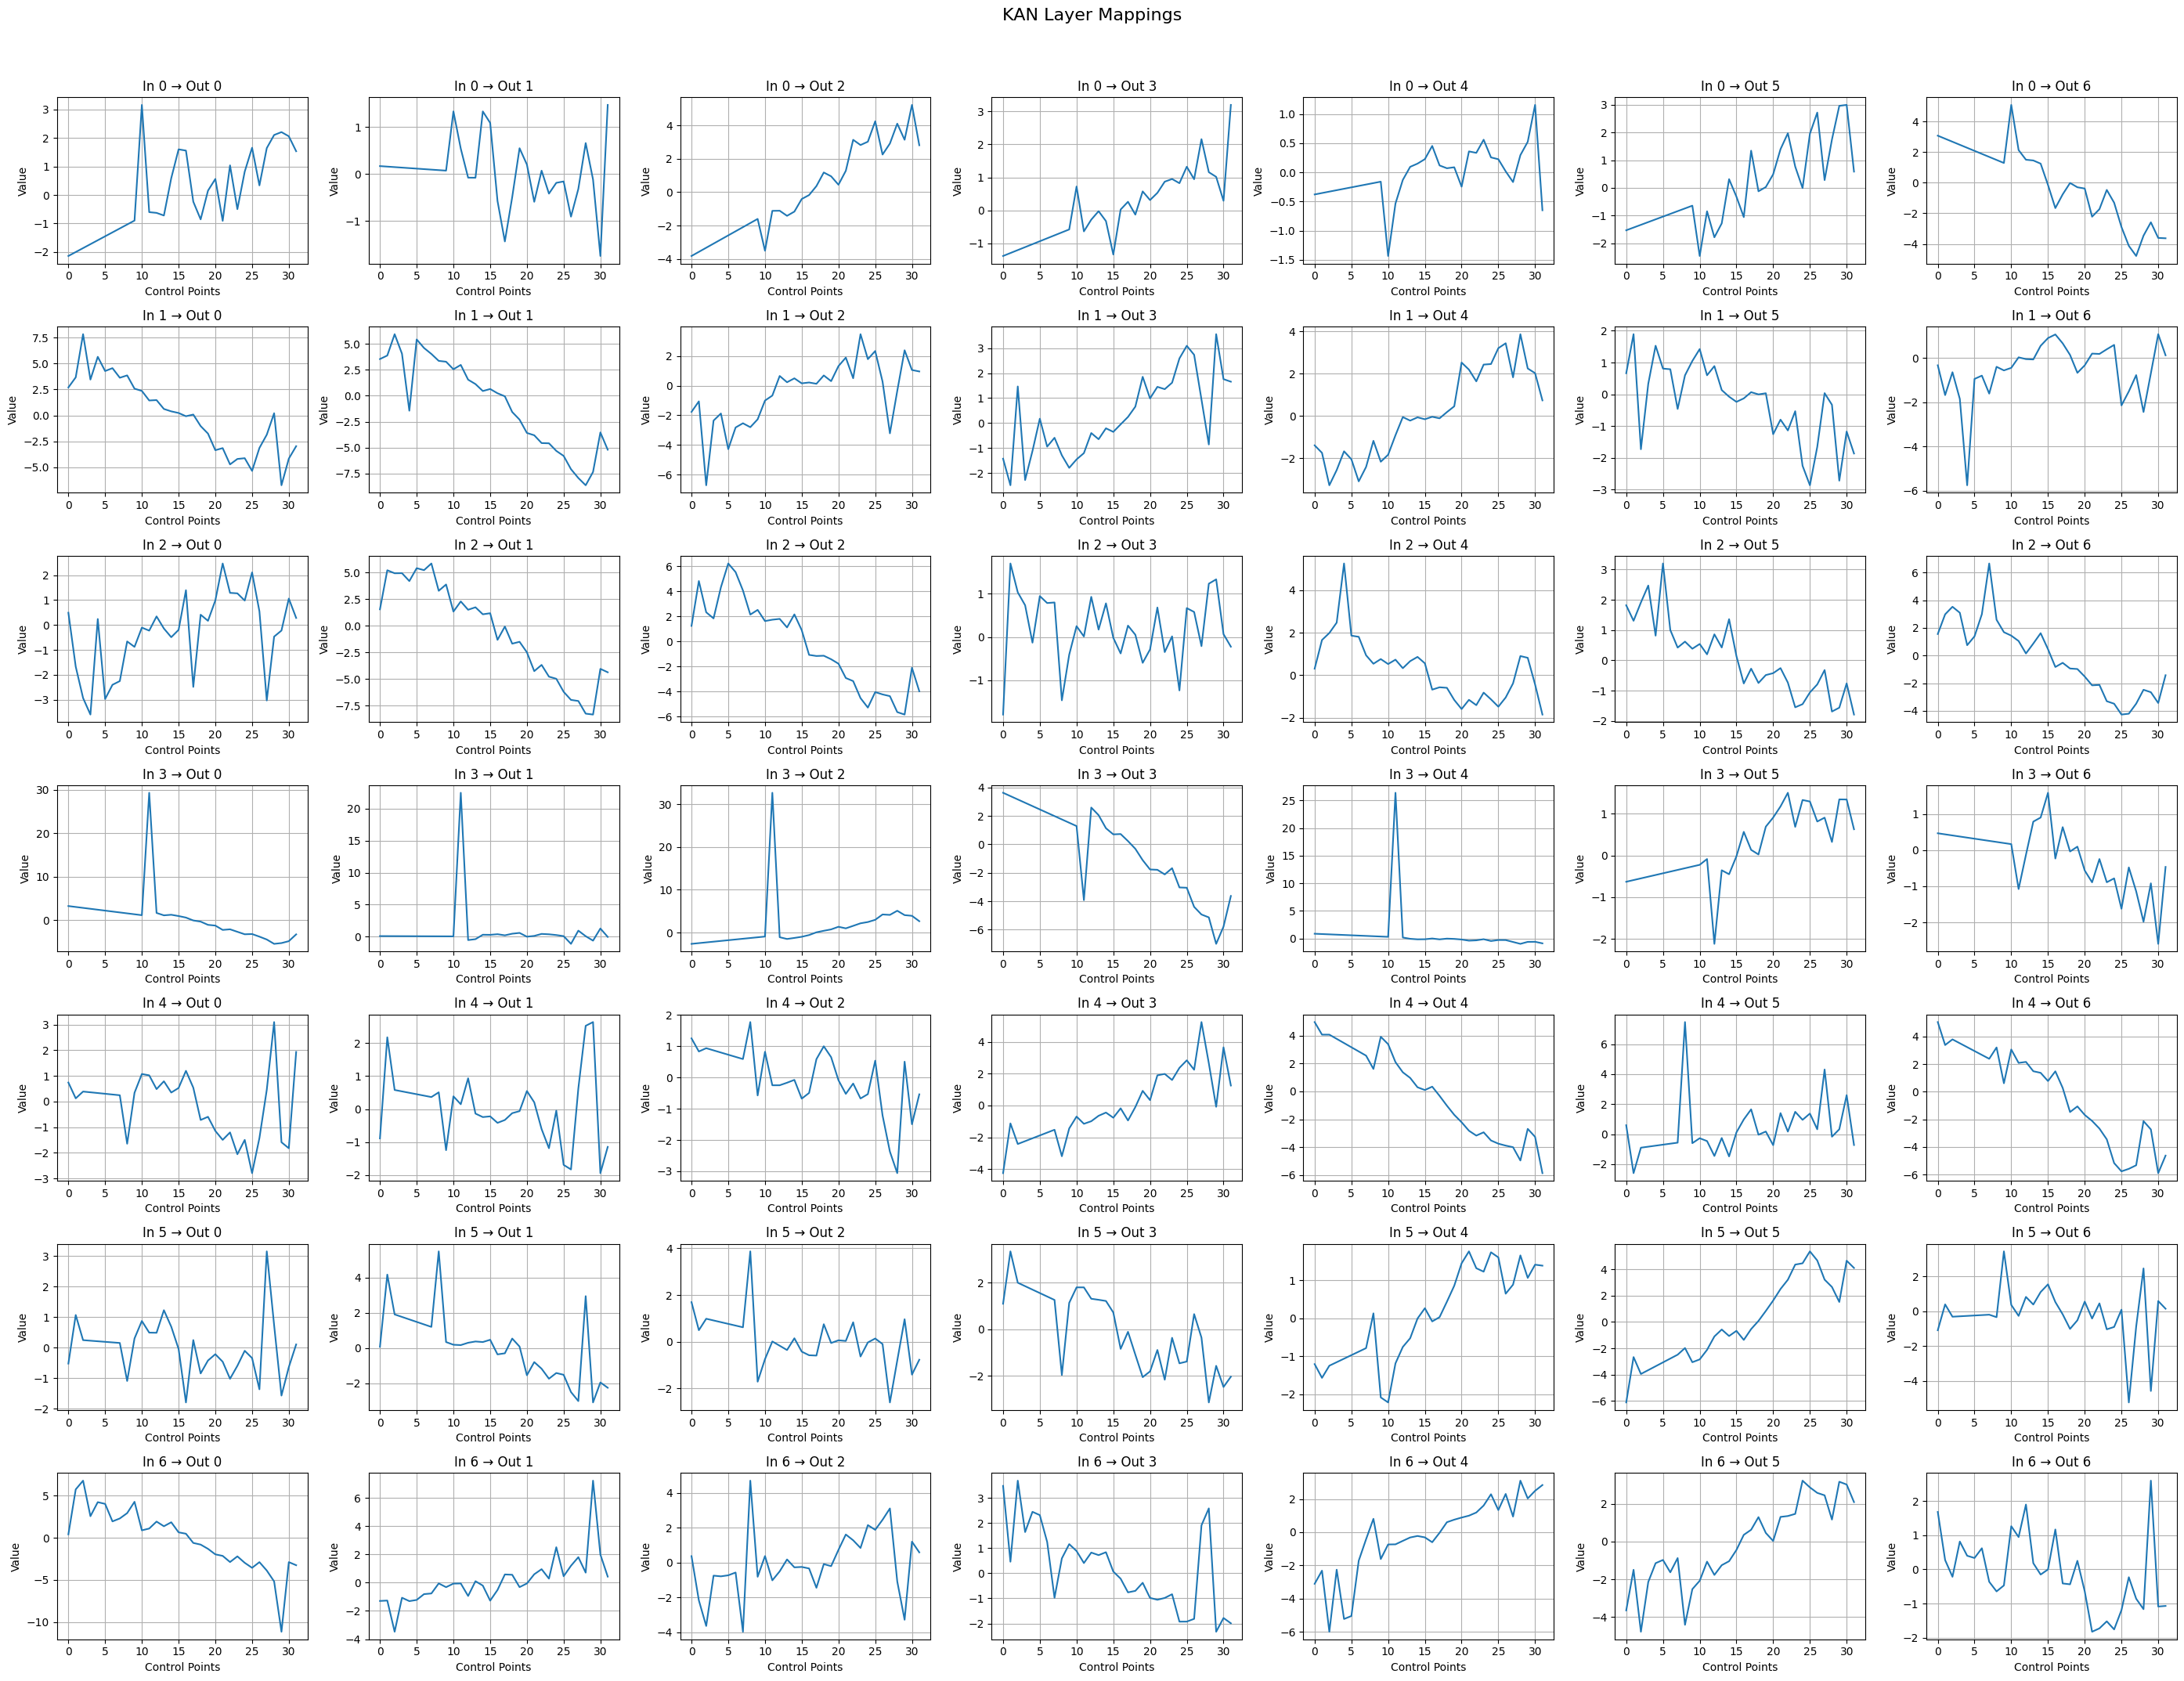

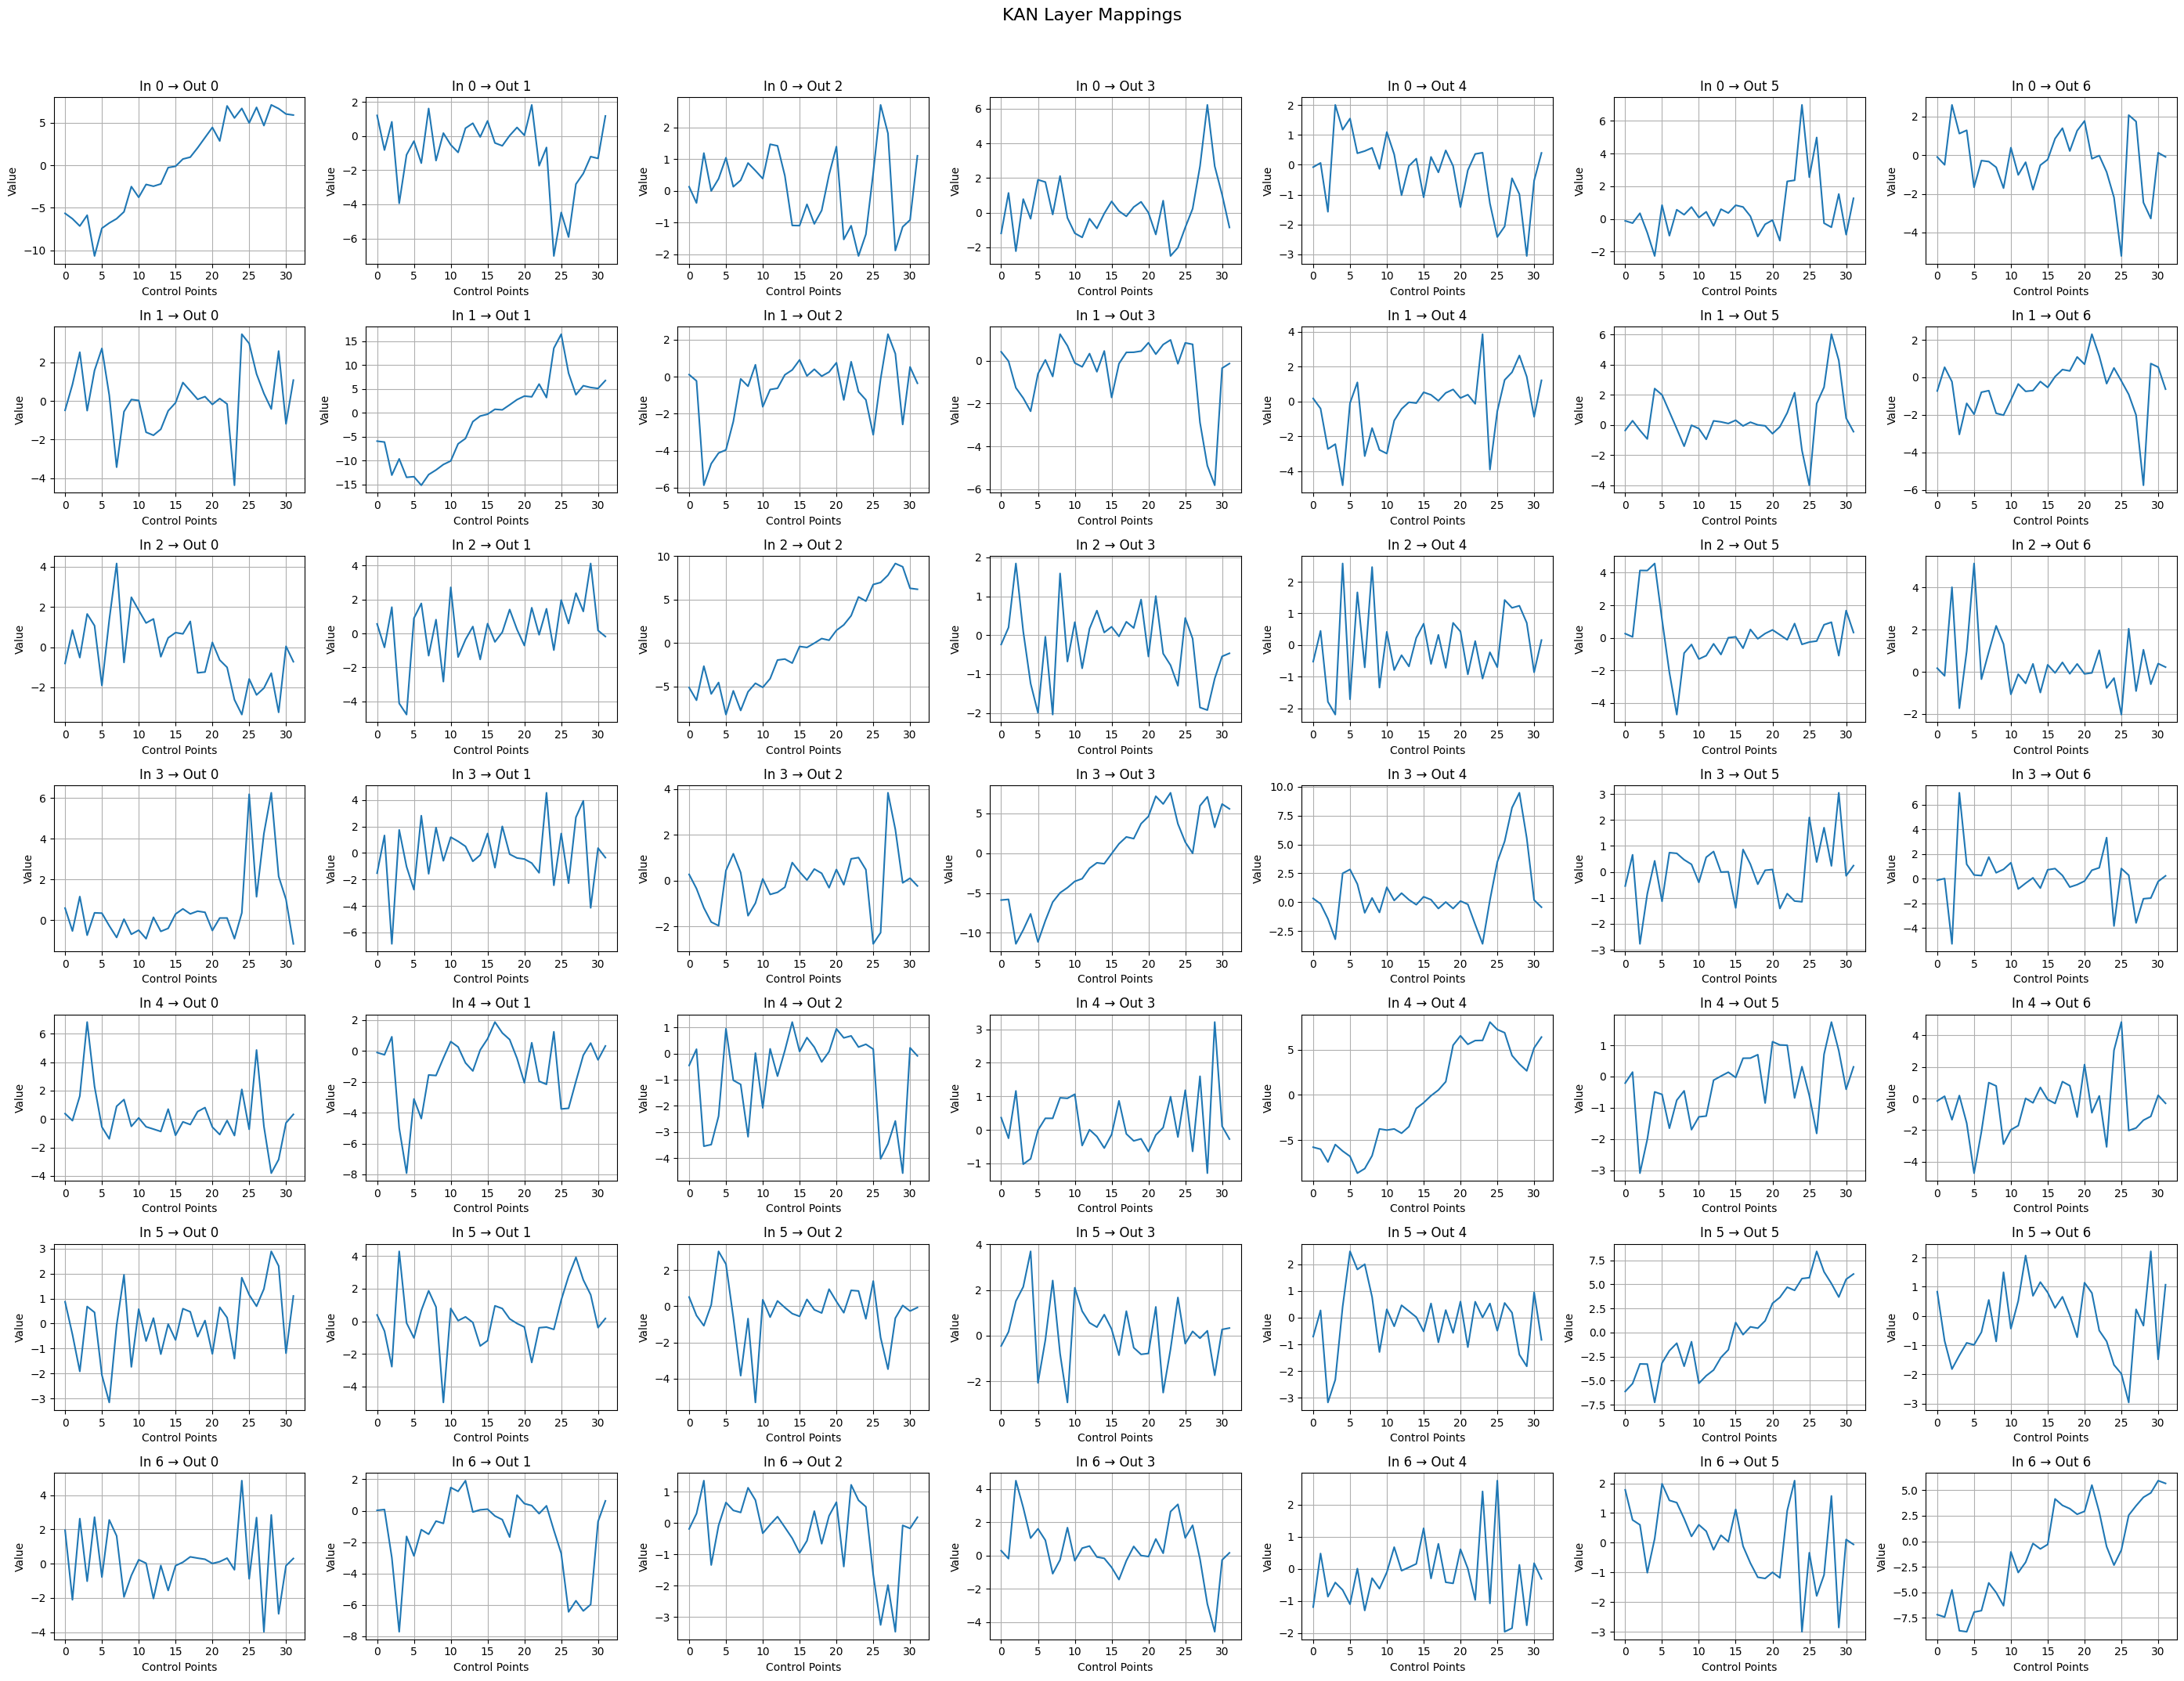

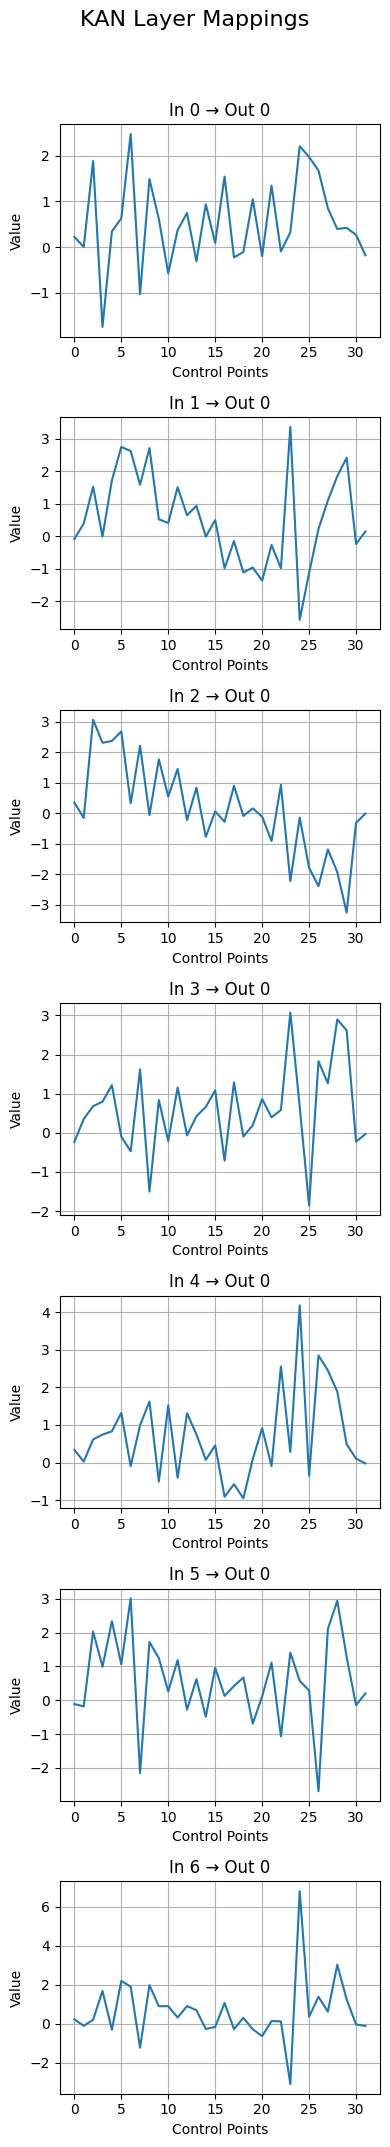

In [114]:
for name, module in model.named_modules():
    if isinstance(module, KANLayer):
        module.visualize_all_mappings()

In [164]:
class StableNN(nn.Module):
    def __init__(self, in_features: int, mid_features: int, out_features: int):
        super().__init__()
        self.mad_bn1 = nn.BatchNorm1d(in_features, momentum=1.0, affine=False)
        self.linear1 = nn.Linear(in_features, mid_features)

        self.mad_bn2 = nn.BatchNorm1d(mid_features, momentum=1.0, affine=False)
        self.linear2 = nn.Linear(mid_features, mid_features)

        self.mad_bn3 = nn.BatchNorm1d(mid_features, momentum=1.0, affine=False)
        self.linear3 = nn.Linear(mid_features, out_features)

        with torch.no_grad():
            l1_norm = torch.norm(self.linear1.weight)
            self.linear1.weight.div_(l1_norm)

            nn.init.eye_(self.linear2.weight)
            nn.init.zeros_(self.linear2.bias)

            nn.init.zeros_(self.linear3.weight)
            nn.init.zeros_(self.linear3.bias)


    def forward(self, x):
        x = self.mad_bn1(x)
        x = self.linear1(x)
        x = F.relu(x)

        x = self.mad_bn2(x)
        x = self.linear2(x)
        x = F.relu(x)

        x = self.mad_bn3(x)
        x = self.linear3(x)
        return torch.cat([x, -x], dim=-1)

In [165]:
model = torch.compile(StableNN(in_features=X.shape[1], mid_features=64, out_features=1), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * 10, weight_decay=0.0)]

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

Epoch 50/1000, Train Loss: 0.332920, Test Loss: 0.337362, Test Acc: 0.8802, LR: 5.0000e-03
Epoch 100/1000, Train Loss: 0.302317, Test Loss: 0.309980, Test Acc: 0.8827, LR: 1.0000e-02
Epoch 150/1000, Train Loss: 0.294149, Test Loss: 0.301770, Test Acc: 0.8846, LR: 9.9971e-03
Epoch 200/1000, Train Loss: 0.294833, Test Loss: 0.300933, Test Acc: 0.8838, LR: 9.9934e-03
Epoch 250/1000, Train Loss: 0.286282, Test Loss: 0.297034, Test Acc: 0.8858, LR: 9.9897e-03
Epoch 300/1000, Train Loss: 0.285383, Test Loss: 0.297109, Test Acc: 0.8827, LR: 9.9853e-03
Epoch 350/1000, Train Loss: 0.284281, Test Loss: 0.298552, Test Acc: 0.8851, LR: 9.9807e-03
Epoch 400/1000, Train Loss: 0.280616, Test Loss: 0.294371, Test Acc: 0.8860, LR: 9.9762e-03
Epoch 450/1000, Train Loss: 0.275839, Test Loss: 0.292644, Test Acc: 0.8857, LR: 9.9723e-03
Epoch 500/1000, Train Loss: 0.277604, Test Loss: 0.294193, Test Acc: 0.8870, LR: 9.9680e-03
Epoch 550/1000, Train Loss: 0.267609, Test Loss: 0.287307, Test Acc: 0.8896, LR: 

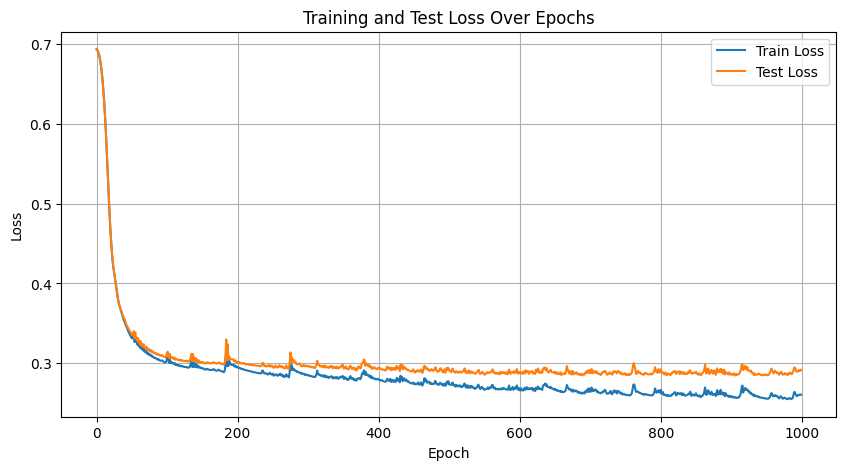

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─StableNN: 1-1                          [43152, 2]                4,737
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21


In [166]:
train(model, criterion, optimizers, epochs=1000, warmup_epochs=100) # type: ignore